# Molecules and Proteins: A Practical Notebook

This notebook is organised into three teaching modules:

1. **Proteins** – how to work with 3D protein structures, build contact maps, and use interactive 3D viewers.
2. **Small molecules** – how to represent molecules with SMILES, fingerprints and scaffolds, and how to explore their chemical space.
3. **Integrated assignment** – a mini workflow that combines single-cell RNA-seq preprocessing with basic molecular modelling and visualisation.


## Part 1 – Protein Structures and Contact Maps

In this part we will:

- Import standard scientific Python tools and structure-handling libraries.
- Load a protein structure from a PDB file.
- Extract Cα coordinates and compute a pairwise distance matrix.
- Convert the distance matrix into a binary **contact map** under a given cut-off.
- Plot the contact map and relate it back to the 3D structure (e.g. using nglview or similar tools).

The key idea is that a protein can be described both as a 3D object in space and as a 2D matrix of residue–residue contacts.

In [ ]:
!pip -q install numpy matplotlib Biopython wget nglview "ipywidgets>=8.1.0"
from google.colab import output
output.enable_custom_widget_manager()


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 29.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 2.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all t

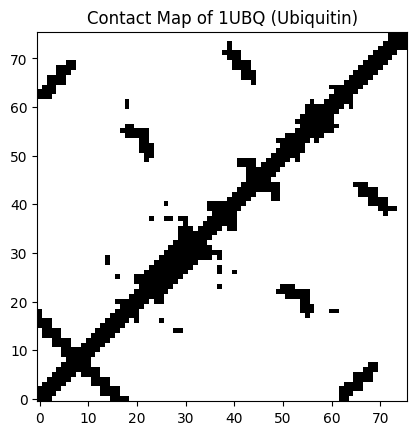

In [ ]:
import Bio.PDB, numpy as np, matplotlib.pyplot as plt
import os, wget

os.makedirs("data", exist_ok=True)
os.makedirs("figure", exist_ok=True)
# download a PDB file from the RCSB PDB database
wget.download("https://files.rcsb.org/download/1UBQ.pdb", "./data/1ubq.pdb")
parser = Bio.PDB.PDBParser()

structure = parser.get_structure("1UBQ", "./data/1ubq.pdb")  # e.g., ubiquitin
# Extract Cα atom coordinates for all residues:
coords = [atom.get_coord() for atom in structure.get_atoms() if atom.get_name() == "CA"]
coords = np.array(coords)
dist_matrix = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)
contact_map = dist_matrix < 8.0  # boolean matrix of contacts under 8Å

plt.imshow(contact_map, cmap="Greys", origin="lower")
plt.title("Contact Map of 1UBQ (Ubiquitin)")
plt.savefig("./figure/contact_map.png")

In [ ]:
import nglview as nv

# Load a structure (by PDB ID or local file)
# view = nv.show_pdbid("1TUP")        # p53 core domain structure from PDB
view = nv.show_file("./data/1ubq.pdb")  # load local AlphaFold model for p53
view.representations = [{"type": "cartoon", "params": {"color": "residueindex"}}]
view

NGLWidget()

## Part 2 – Small-Molecule Representations and Chemical Space

Now we switch from protein structures to **small molecules**. In this part we will:

- Install and import **RDKit** and other chemistry tools.
- Convert SMILES strings to canonical forms.
- Compute simple fingerprints such as **MACCS keys**.
- Generate 2D drawings and basic 3D conformers.
- Visualise a small set of molecules in **chemical space** using dimensionality reduction.
- Take a first look at scaffolds and scaffold networks.

Again, try to connect the code to the concepts: molecular graphs, fingerprints, similarity, and the geometry of conformers.

In [ ]:
!pip -q install rdkit chemplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 7.2 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem

mol = Chem.MolFromSmiles("OC(=O)C1=CC=CC=C1OC(=O)C")
canonical = Chem.MolToSmiles(mol, canonical=True)
print(canonical)  # Output: CC(=O)Oc1ccccc1C(=O)O


CC(=O)Oc1ccccc1C(=O)O


In [ ]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys

# Read a molecule, e.g. benzene
smiles = 'c1ccccc1'
mol = Chem.MolFromSmiles(smiles)

# Compute MACCS keys
maccs_fp = MACCSkeys.GenMACCSKeys(mol)

# Output as a bit vector
print(maccs_fp)                # print directly
print(list(maccs_fp))          # convert to a list (vector of 0/1)
print(maccs_fp.GetNumBits())   # check length (typically 167 bits; bit 0 unused)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
167


In [ ]:
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolAlign

# Generate 3D conformer for aspirin
aspirin_smiles = "CC(=O)Oc1ccccc1C(=O)O"  # Aspirin SMILES
mol = Chem.MolFromSmiles(aspirin_smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(mol)


# Generate image from 3D conformer
img_3d = Draw.MolToImage(mol, size=(300, 300), legend="Aspirin 3D (conformer)")
image_path_3d = "./figure/aspirin_3d.png"
img_3d.save(image_path_3d)
mol.GetConformer(0).GetPositions()

array([[-2.97576171, -2.22380912, -0.02059721],
       [-2.092062  , -1.11480107, -0.48017624],
       [-2.37929023, -0.48953896, -1.53673148],
       [-0.89964197, -0.85953592,  0.20925149],
       [-0.09550004,  0.28072684,  0.04771646],
       [-0.66776787,  1.52817245, -0.27068184],
       [ 0.13337369,  2.66079203, -0.41651425],
       [ 1.51158545,  2.56880528, -0.23683092],
       [ 2.094108  ,  1.34559003,  0.09821735],
       [ 1.30459052,  0.18950704,  0.25089084],
       [ 1.96640102, -1.09210709,  0.60952726],
       [ 1.30004054, -2.15487541,  0.73225283],
       [ 3.34352446, -1.133072  ,  0.81467145],
       [-4.03741472, -1.98280678, -0.23976071],
       [-2.86021208, -2.36990853,  1.07378813],
       [-2.69611222, -3.16095931, -0.54507323],
       [-1.73850763,  1.63572927, -0.37766396],
       [-0.31712793,  3.61430273, -0.66054252],
       [ 2.13056723,  3.44967488, -0.34922221],
       [ 3.16703975,  1.30760478,  0.23835839],
       [ 3.80816775, -1.99949114,  1.059

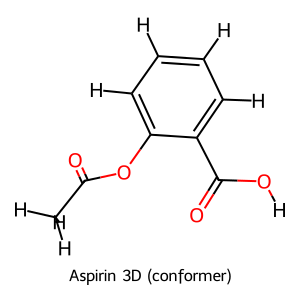

In [ ]:
img_3d

[06:24:49] DEPRECATION WARNING: please use MorganGenerator
[06:24:49] DEPRECATION WARNING: please use MorganGenerator
[06:24:49] DEPRECATION WARNING: please use MorganGenerator
[06:24:49] DEPRECATION WARNING: please use MorganGenerator
[06:24:49] DEPRECATION WARNING: please use MorganGenerator
[06:24:49] DEPRECATION WARNING: please use MorganGenerator


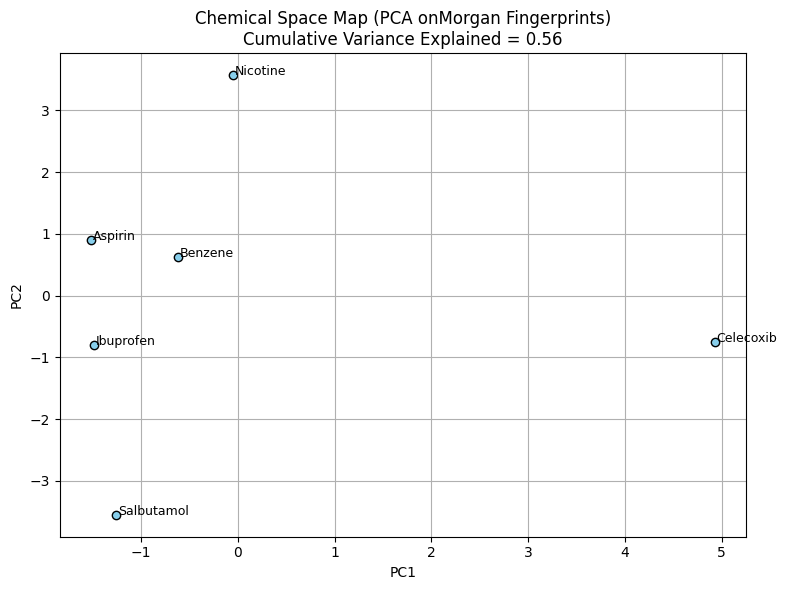

'./figure/pca_plot_annotated.png'

In [ ]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt

def fp2arr(fp):
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Define molecules with names
molecules = {
    "Aspirin": "CC(=O)Oc1ccccc1C(=O)O",
    "Celecoxib": "CC1=CC=C(C=C1)C2=CC("+ \
        "=NN2C3=CC=C(C=C3)S(=O)(=O)N)C(F)(F)F",
    "Benzene": "C1=CC=CC=C1",
    "Ibuprofen": "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",
    "Nicotine": "CN1CCC[C@H]1C2=CN=CC=C2",
    "Salbutamol": "CC(C)(C)NCC(C1=CC(=C(C=C1)O)CO)O"
}

# Compute fingerprints
fps = [AllChem.GetMorganFingerprintAsBitVect(
        Chem.MolFromSmiles(smiles), 2, 1024)
     for smiles in molecules.values()]
arr = np.array([fp2arr(fp) for fp in fps])

# Perform PCA
pca = PCA(n_components=2)
res = pca.fit_transform(arr)
pc = res.T

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(pc[0], pc[1], marker="o",
    color='skyblue', edgecolors='k')

# Annotate points
for i, name in enumerate(molecules.keys()):
    plt.text(pc[0][i] + 0.02, pc[1][i], name, fontsize=9)

cum_cr = sum(pca.explained_variance_ratio_)
plt.title("Chemical Space Map (PCA on" + \
    "Morgan Fingerprints)\n" + \
    "Cumulative Variance Explained = %.2f" % cum_cr)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()

img_path = "./figure/pca_plot_annotated.png"
plt.savefig(img_path)
plt.show()
img_path


In [ ]:
!pip install matplotlib

sim_type indicates the similarity type by which the plots are constructed.
The supported similarity types are structural and tailored.
Because no target list has been provided 'structural' as been selected as sym_type.


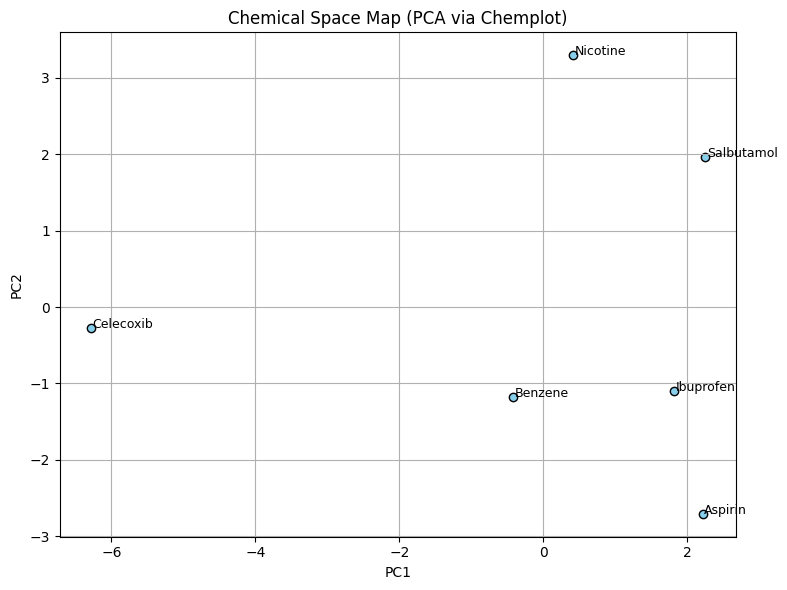

In [ ]:
from chemplot import Plotter
from matplotlib import pyplot as plt

# Define molecules
molecules = {
    "Aspirin": "CC(=O)Oc1ccccc1C(=O)O",
    "Celecoxib": "CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)N)C(F)(F)F",
    "Benzene": "C1=CC=CC=C1",
    "Ibuprofen": "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",
    "Nicotine": "CN1CCC[C@H]1C2=CN=CC=C2",
    "Salbutamol": "CC(C)(C)NCC(C1=CC(=C(C=C1)O)CO)O"
}
smiles_list = list(molecules.values())
labels = list(molecules.keys())

# Generate Chemplot PCA map
cp = Plotter.from_smiles(smiles_list)
coords = cp.pca()

# Plot with annotations
plt.figure(figsize=(8, 6))
plt.scatter(coords.iloc[:, 0], coords.iloc[:, 1], color='skyblue', edgecolors='k')

# Add text labels
for i, name in enumerate(labels):
    plt.text(coords.iloc[i, 0] + 0.02, coords.iloc[i, 1], name, fontsize=9)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Chemical Space Map (PCA via Chemplot)")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2327825362.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


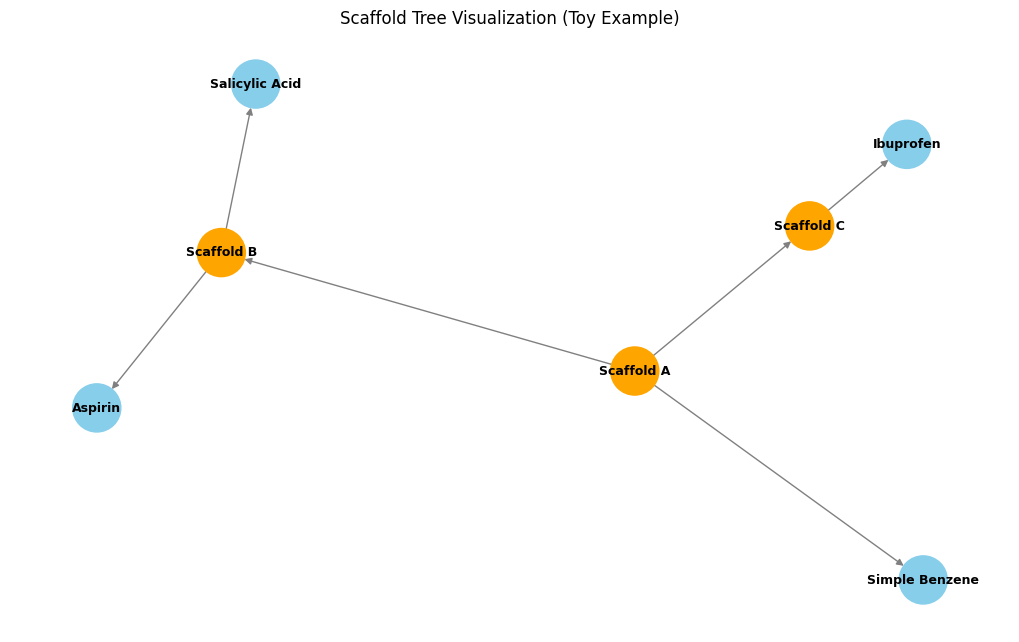

'./figure/scaffold_tree_demo.png'

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a toy scaffold hierarchy for illustration
G = nx.DiGraph()

# Add nodes for scaffolds and compounds
G.add_node("Scaffold A", type='scaffold')
G.add_node("Scaffold B", type='scaffold')
G.add_node("Scaffold C", type='scaffold')
G.add_node("Aspirin", type='compound')
G.add_node("Ibuprofen", type='compound')
G.add_node("Salicylic Acid", type='compound')
G.add_node("Simple Benzene", type='compound')

# Add scaffold relationships
G.add_edge("Scaffold A", "Scaffold B")
G.add_edge("Scaffold A", "Scaffold C")
G.add_edge("Scaffold B", "Aspirin")
G.add_edge("Scaffold B", "Salicylic Acid")
G.add_edge("Scaffold C", "Ibuprofen")
G.add_edge("Scaffold A", "Simple Benzene")

# Draw the network
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 6))
node_colors = ['skyblue' if G.nodes[n]['type'] == 'compound' else 'orange' for n in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1200, font_size=9, edge_color='gray', font_weight='bold')
plt.title("Scaffold Tree Visualization (Toy Example)")
plt.tight_layout()

img_path = "./figure/scaffold_tree_demo.png"
plt.savefig(img_path)
plt.show()
img_path


In [ ]:
!pip -q install py3Dmol scikit-learn scaffoldgraph adjustText  gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
import py3Dmol
import requests

# Download PDB file
pdb_id = '1OXR'
pdb_url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
pdb_data = requests.get(pdb_url).text

# Visualization setup
view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_data, 'pdb')

# Display protein chain A as cartoon
view.setStyle({'chain': 'A'}, {'cartoon': {'color': 'blue'}})

# Display ligand AIN as sticks
view.setStyle({'resn': 'AIN'}, {'stick': {'color': 'magenta'}})

# Display calcium ions (CA) as spheres
view.setStyle({'resn': 'CA'}, {'sphere': {'radius': 0.8, 'color': 'yellow'}})

# Optional: add a surface for the protein-ligand complex
view.addSurface(py3Dmol.VDW, {'opacity': 0.2})

# Zoom to the ligand region
view.zoomTo({'resn': 'AIN'})

# Render the viewer
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=15cZMqC0iWmNCrTcy3WdyveYGvL-feXTa
From (redirected): https://drive.google.com/uc?id=15cZMqC0iWmNCrTcy3WdyveYGvL-feXTa&confirm=t&uuid=02ee24e7-6242-44aa-99d2-85badc173bbb
To: /content/data/NSAIDs.smi
100% 6.07k/6.07k [00:00<00:00, 8.32MB/s]
sim_type indicates the similarity type by which the plots are constructed.
The supported similarity types are structural and tailored.
Because no target list has been provided 'structural' as been selected as sym_type.


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


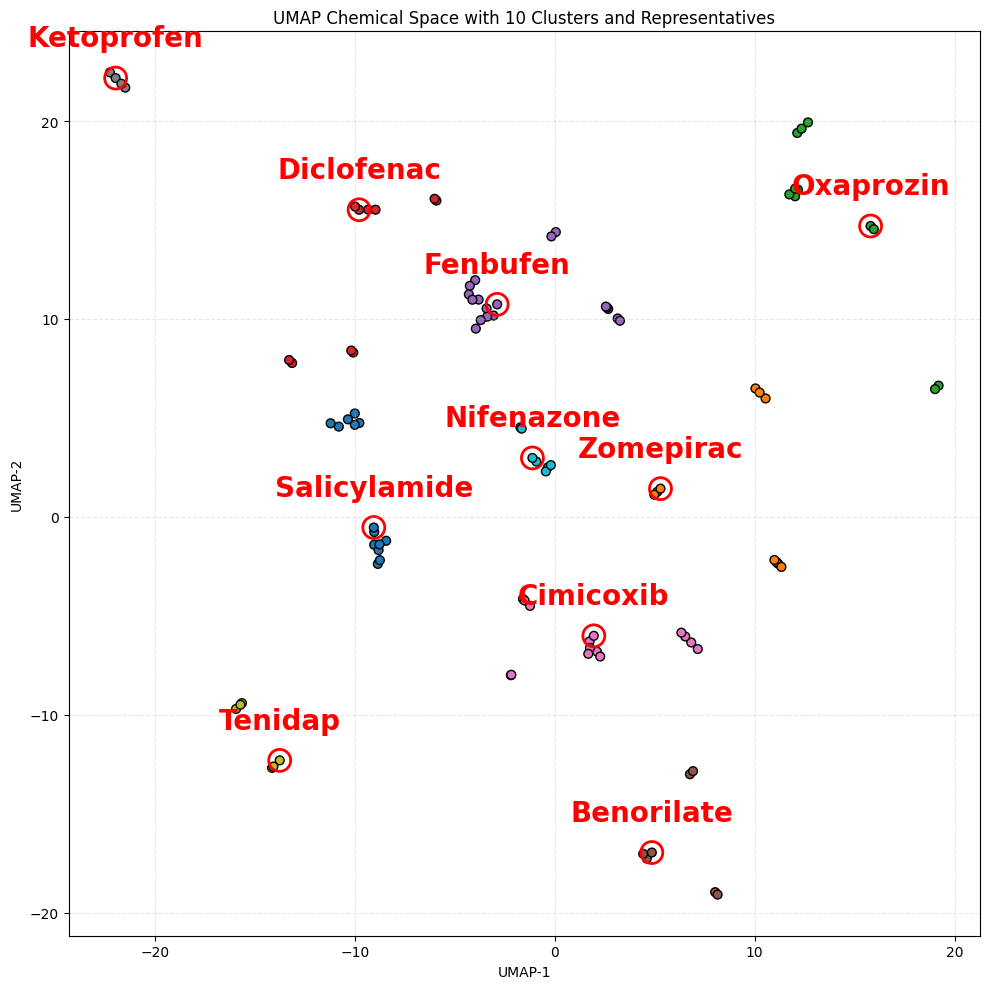

In [ ]:
!gdown --id 15cZMqC0iWmNCrTcy3WdyveYGvL-feXTa -O data/NSAIDs.smi
import matplotlib.pyplot as plt
from adjustText import adjust_text
from rdkit import Chem
from chemplot import Plotter
import gdown


# ---- Load data ---------------------------------------------------------------
smiles_list = [s.split(" ")[0] for s in open('./data/NSAIDs.smi')]
labels      = [s.split("#")[1].strip() for s in open('./data/NSAIDs.smi')]

cp     = Plotter.from_smiles(smiles_list)
coords = cp.umap(random_state=500)                      # compute UMAP coordinates
clusters =  cp.cluster(n_clusters=10)["clusters"]

X = coords.to_numpy()                        # (n_samples, 2)

# ---------- Identify one representative per cluster ----------
rep_indices = []          # store row-index of chosen molecules
for cid in np.unique(clusters):
    idx      = np.where(clusters == cid)[0]      # indices of points in this cluster
    cluster_pts = X[idx]                         # coordinates of those points
    centroid  = cluster_pts.mean(axis=0)         # 2-D centroid
    # choose point with smallest Euclidean distance to centroid
    rep_idx   = idx[np.linalg.norm(cluster_pts - centroid, axis=1).argmin()]
    rep_indices.append(rep_idx)

# ---------------- Plot with cluster colours ----------------
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(X[:, 0], X[:, 1],
                     c=clusters, cmap='tab10', edgecolors='k', s=40)

# highlight representatives
for i in rep_indices:
    ax.scatter(X[i, 0], X[i, 1], s=250,
               facecolors='none', edgecolors='red', lw=2)
    ax.text(X[i, 0], X[i, 1]+2, labels[i],
            fontsize=20, weight='bold', color='red', ha='center', va='center')

ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_title('UMAP Chemical Space with 10 Clusters and Representatives')
plt.grid(True, ls='--', alpha=0.3)
plt.tight_layout()
plt.show()